# Forecasting

In [693]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import Holt, ExponentialSmoothing

warnings.filterwarnings('ignore')

Reading the saas data.

In [694]:
#Reading the saas dataset and assigning it to df
df = pd.read_csv('saas.csv', index_col = 0)

In [695]:
#changing all the letters in the columns names to lowercase
df.columns = df.columns.str.lower()

In [696]:
# changing the dtype of the index to datetime
df.index = pd.to_datetime(df.index)

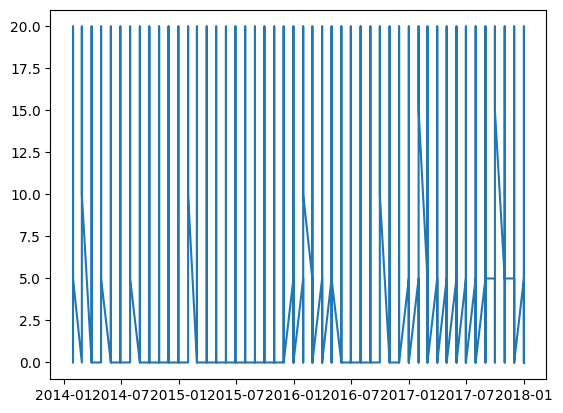

In [697]:
plt.plot(df.amount)
plt.show()

### 1) 
Split data (train/test) and resample by any period, except daily, and aggregate using the sum.   

In [698]:
df.index

DatetimeIndex(['2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31',
               '2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31',
               '2014-01-31', '2014-01-31',
               ...
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='Month_Invoiced', length=790458, freq=None)

In [699]:
# Calculate the number of rows for each set based on the desired percentages
total_rows = len(df)
train_size = int(0.7 * total_rows)
val_size = int(0.15 * total_rows)

# Split the data into training, validation, and test sets
train = df.iloc[:train_size]
val = df.iloc[train_size:train_size + val_size]
test = df.iloc[train_size + val_size:]
train.shape, val.shape, test.shape

((553320, 4), (118568, 4), (118570, 4))

In [700]:
#resampling weekly and aggregating by sum.
month_train = train.resample('M')['amount'].sum()
month_val = val.resample('M')['amount'].sum()
month_test = test.resample('M')['amount'].sum()

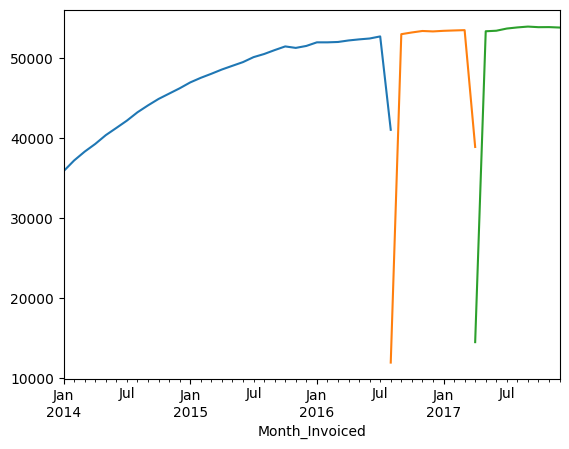

In [701]:
#visualizing the split
month_train.plot()
month_val.plot()
month_test.plot()
plt.show()

Baseline model

In [702]:
#weekly rolling average baseline 
three_month_rolling = round(month_train.rolling(3).mean()[-1], 2)
three_month_rolling

48716.67

In [703]:
#creating a dataframe with weekly rolling and the actual values from week_val
preds = pd.DataFrame({'actual': month_val,
                      '3_month_rolling': three_month_rolling})

preds.head()

,actual,3_month_rolling
Month_Invoiced,,
2016-08-31,11920.0,48716.67
2016-09-30,52975.0,48716.67
2016-10-31,53190.0,48716.67
2016-11-30,53375.0,48716.67
2016-12-31,53320.0,48716.67


In [704]:
#monthly rolling average baseline
monthly_rolling = round(month_train.rolling(1).mean()[-1], 2)
monthly_rolling

41020.0

In [705]:
#creating a dataframe with monthly rolling and the actual values from week_val
preds['monthly_rolling'] = monthly_rolling
preds.head()

,actual,3_month_rolling,monthly_rolling
Month_Invoiced,,,
2016-08-31,11920.0,48716.67,41020.0
2016-09-30,52975.0,48716.67,41020.0
2016-10-31,53190.0,48716.67,41020.0
2016-11-30,53375.0,48716.67,41020.0
2016-12-31,53320.0,48716.67,41020.0


Evaluating both rolling baselines

In [706]:
#weekly rolling average baseline
round(sqrt(mean_squared_error(preds['actual'], preds['3_month_rolling'])), 2)

13328.22

In [707]:
#monthly rolling average baseline
round(sqrt(mean_squared_error(preds['actual'], preds['monthly_rolling'])), 2)

14564.14

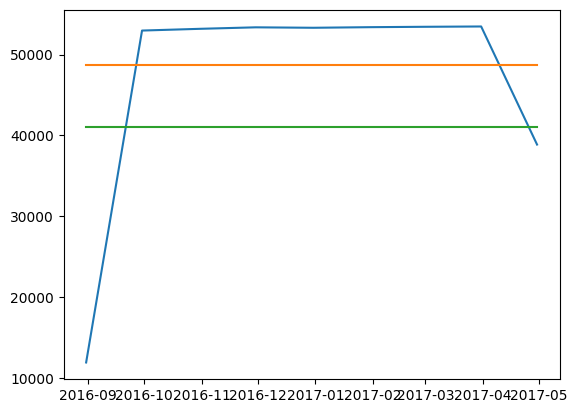

In [708]:
plt.plot(preds['actual'])
plt.plot(preds['3_month_rolling'])
plt.plot(preds['monthly_rolling'])
plt.show()

## 2)
  Forecast, plot and evaluate using each at least 4 of the methods we discussed:   
- Last Observed Value   
- Simple Average   
- Moving Average   
- Holt's Linear Trend   
- Holt's Seasonal Trend   
Based on previous year/month/etc., this is up to you.

## Holt-Winters Exponential Smoothing method with both a seasonal and a trend component.

In [709]:
# Fit an Exponential Smoothing model with Holt-Winters method to the training data
hst_model = ExponentialSmoothing(month_train, seasonal_periods=3, trend='add', seasonal='add').fit()

In [710]:
# Generate forecasts using the fitted Holt-Winters Exponential Smoothing model
preds['hst'] = hst_model.forecast(month_val.shape[0])

In [711]:
preds = preds.fillna(preds.hst.mean())

In [712]:
#model rmse
round(sqrt(mean_squared_error(preds['actual'], preds['hst'])), 2)

40269.34

## Holt's Linear Trend

In [713]:
# Fit Holt's Linear Trend model to the time series data
model_fit = ExponentialSmoothing(month_train, trend='add', seasonal='add', seasonal_periods=2).fit()

# Generate forecasts for future time periods
preds['hlt'] = model_fit.forecast(month_val.shape[0]) 

In [714]:
preds = preds.fillna(preds.hlt.mean())

In [715]:
#model rmse
round(sqrt(mean_squared_error(preds['actual'], preds['hlt'])), 2)

17182.5

## Holt-Winters Exponential Smoothing method with both a seasonal and a trend component.

In [716]:
# Fit an Exponential Smoothing model with Holt-Winters method to the training data
hst_model2 = ExponentialSmoothing(month_train, seasonal_periods=10, trend='add', seasonal='add').fit()

In [717]:
# Generate forecasts using the fitted Holt-Winters Exponential Smoothing model
preds['hst2'] = hst_model2.forecast(month_val.shape[0])

In [718]:
preds = preds.fillna(preds.hst.mean())

In [719]:
#model rmse
round(sqrt(mean_squared_error(preds['actual'], preds['hst2'])), 2)

9547.91

## Holt's Linear Trend

In [720]:
# Fit Holt's Linear Trend model to the time series data
model_fit2 = ExponentialSmoothing(month_train, trend='add', seasonal='add', seasonal_periods=5).fit()

# Generate forecasts for future time periods
preds['hlt2'] = model_fit2.forecast(month_val.shape[0]) 

In [721]:
preds = preds.fillna(preds.hlt.mean())

In [722]:
#model rmse
round(sqrt(mean_squared_error(preds['actual'], preds['hlt2'])), 2)

24322.63

### Plotting all predictions

## Holt-Winters Exponential Smoothing method with both a seasonal and a trend component.

In [723]:
# Fit an Exponential Smoothing model with Holt-Winters method to the training data
hst_model3 = ExponentialSmoothing(month_train, seasonal_periods=16, trend='add', seasonal='add').fit()

In [724]:
# Generate forecasts using the fitted Holt-Winters Exponential Smoothing model
preds['hst3'] = hst_model2.forecast(month_val.shape[0])
preds = preds.fillna(preds.hst.mean())

In [725]:
#model rmse
round(sqrt(mean_squared_error(preds['actual'], preds['hst3'])), 2)

9547.91

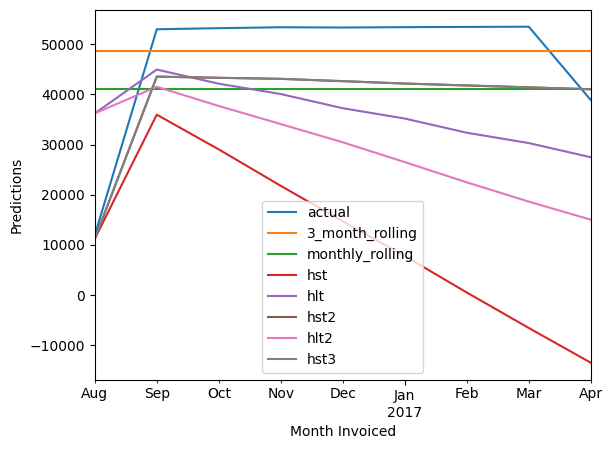

In [726]:
preds.plot()
plt.xlabel('Month Invoiced')
plt.ylabel('Predictions')
plt.show()